# Libs

In [ ]:
suppressPackageStartupMessages({
    library(cygnus)

    ## Consider adding dependencies
    library(Matrix)
    library(dplyr)
    library(data.table)
    library(purrr)

    ## Remove these dependencies 
    library(RSpectra)
    library(sf) ## my own polygons, sf only for plotting? 
    library(mclust) ## mclustBIC. Just use RcppArmadillo's version 

    ## Move to suggests 
    ## (for vignette only, not method)
    library(ggthemes)
    library(viridis)
    library(glue)
    library(patchwork)
    library(ggplot2)
    library(ComplexHeatmap)
})

fig.size <- function(h, w) {
    options(repr.plot.height = h, repr.plot.width = w)
}



# Data

Small sample MERFISH dataset from Chen et al: 

https://www.biorxiv.org/content/10.1101/2023.04.04.535379v1.abstract


In [5]:
counts = readRDS('../data/counts1.rds')
meta_data = readRDS('../data/meta1.rds')
meta_vars_include = c('type_lvl1', 'type_lvl2', 'hubID')


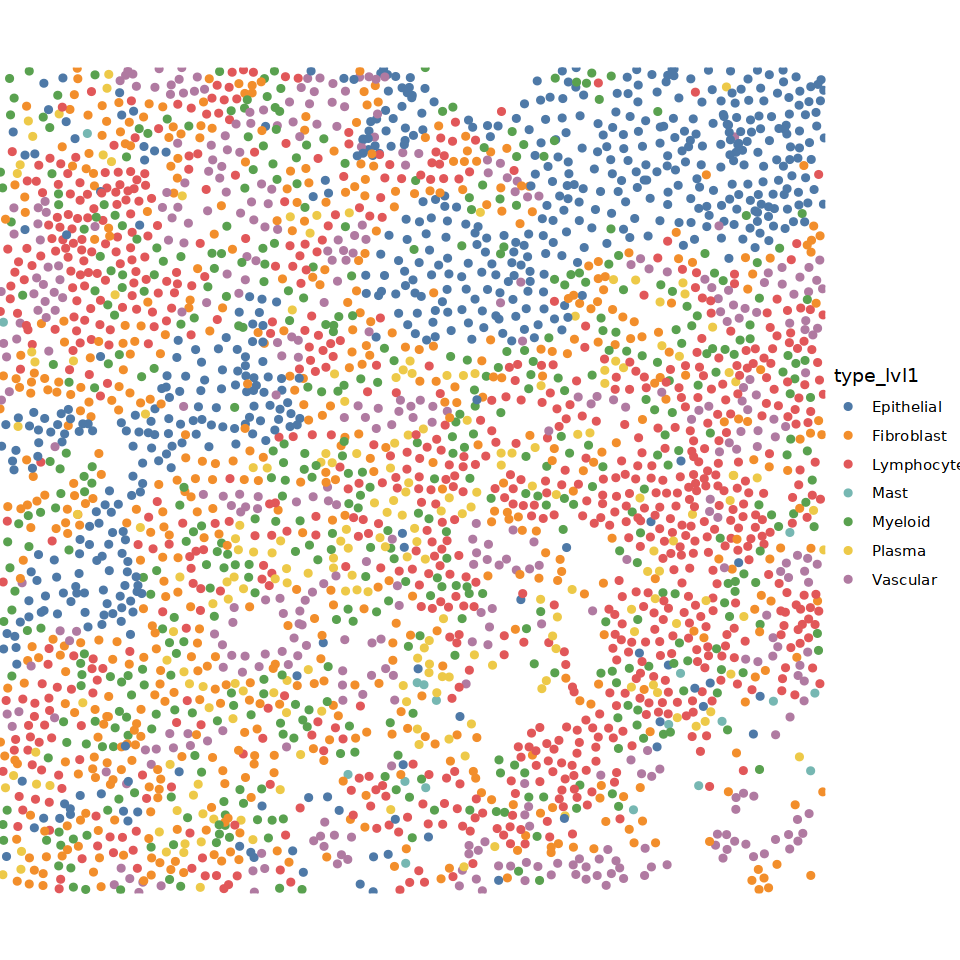

In [6]:
fig.size(8, 8)
ggplot() + 
    geom_point(data = meta_data, aes(X, Y, color = type_lvl1)) + 
    theme_void() + 
    scale_color_tableau() + 
    coord_sf(expand = FALSE) + 
    NULL


Some coarse and fine grained cell types are predefined here, to help interpret the tiles we get below. 

In [7]:
table(meta_data$type_lvl1)


Epithelial Fibroblast Lymphocyte       Mast    Myeloid     Plasma   Vascular 
       634        588        829         18        491        206        411 

In [8]:
table(meta_data$type_lvl2)


                           B               CD1C+ITGAX+ DC 
                          46                           12 
                       CD4 T                        CD8 T 
                         351                           61 
          CXCL10+ Macrophage                CXCL13+ CD4 T 
                          34                           27 
               CXCL13+ CD8 T                   Epithelial 
                           6                          634 
        FCN1+LYZ+ Macrophage                   Fibroblast 
                          11                          588 
                    FLT3+ DC       FOLR2+CD14+ Macrophage 
                           8                          113 
                         ILC         LAMP3+CCL19+ mreg DC 
                          63                           29 
              LAMP3+CD1C+ DC            MARCO+ Macrophage 
                           6                           18 
                        Mast            MERTK+ Macropha

# Get Tiles

Run the Cygnus algorithm to get tiles in one function. The result is returns in two structures: 

1) dmt: cell-level information. 
2) aggs: tile-level information. 

The two are tied together through `dmt$pts$agg_id`


In [9]:
res = GetTiles(
    meta_data$X, meta_data$Y, counts, meta_data, c('type_lvl1', 'type_lvl2'),
    max_npts = 50, 
    min_npts = 5,
    smooth_distance = 'projected', smooth_similarity = 'projected' ## Typically more discriminative 
    # smooth_distance = 'none', smooth_similarity = 'none' ## DEFAULT
)
dmt = res$dmt
aggs = res$aggs


STEP 0: PREPARE DATA STRUCTURES

STEP 1: GRADIENTS 

STEP 2: DMT

STEP 3: AGGREGATION



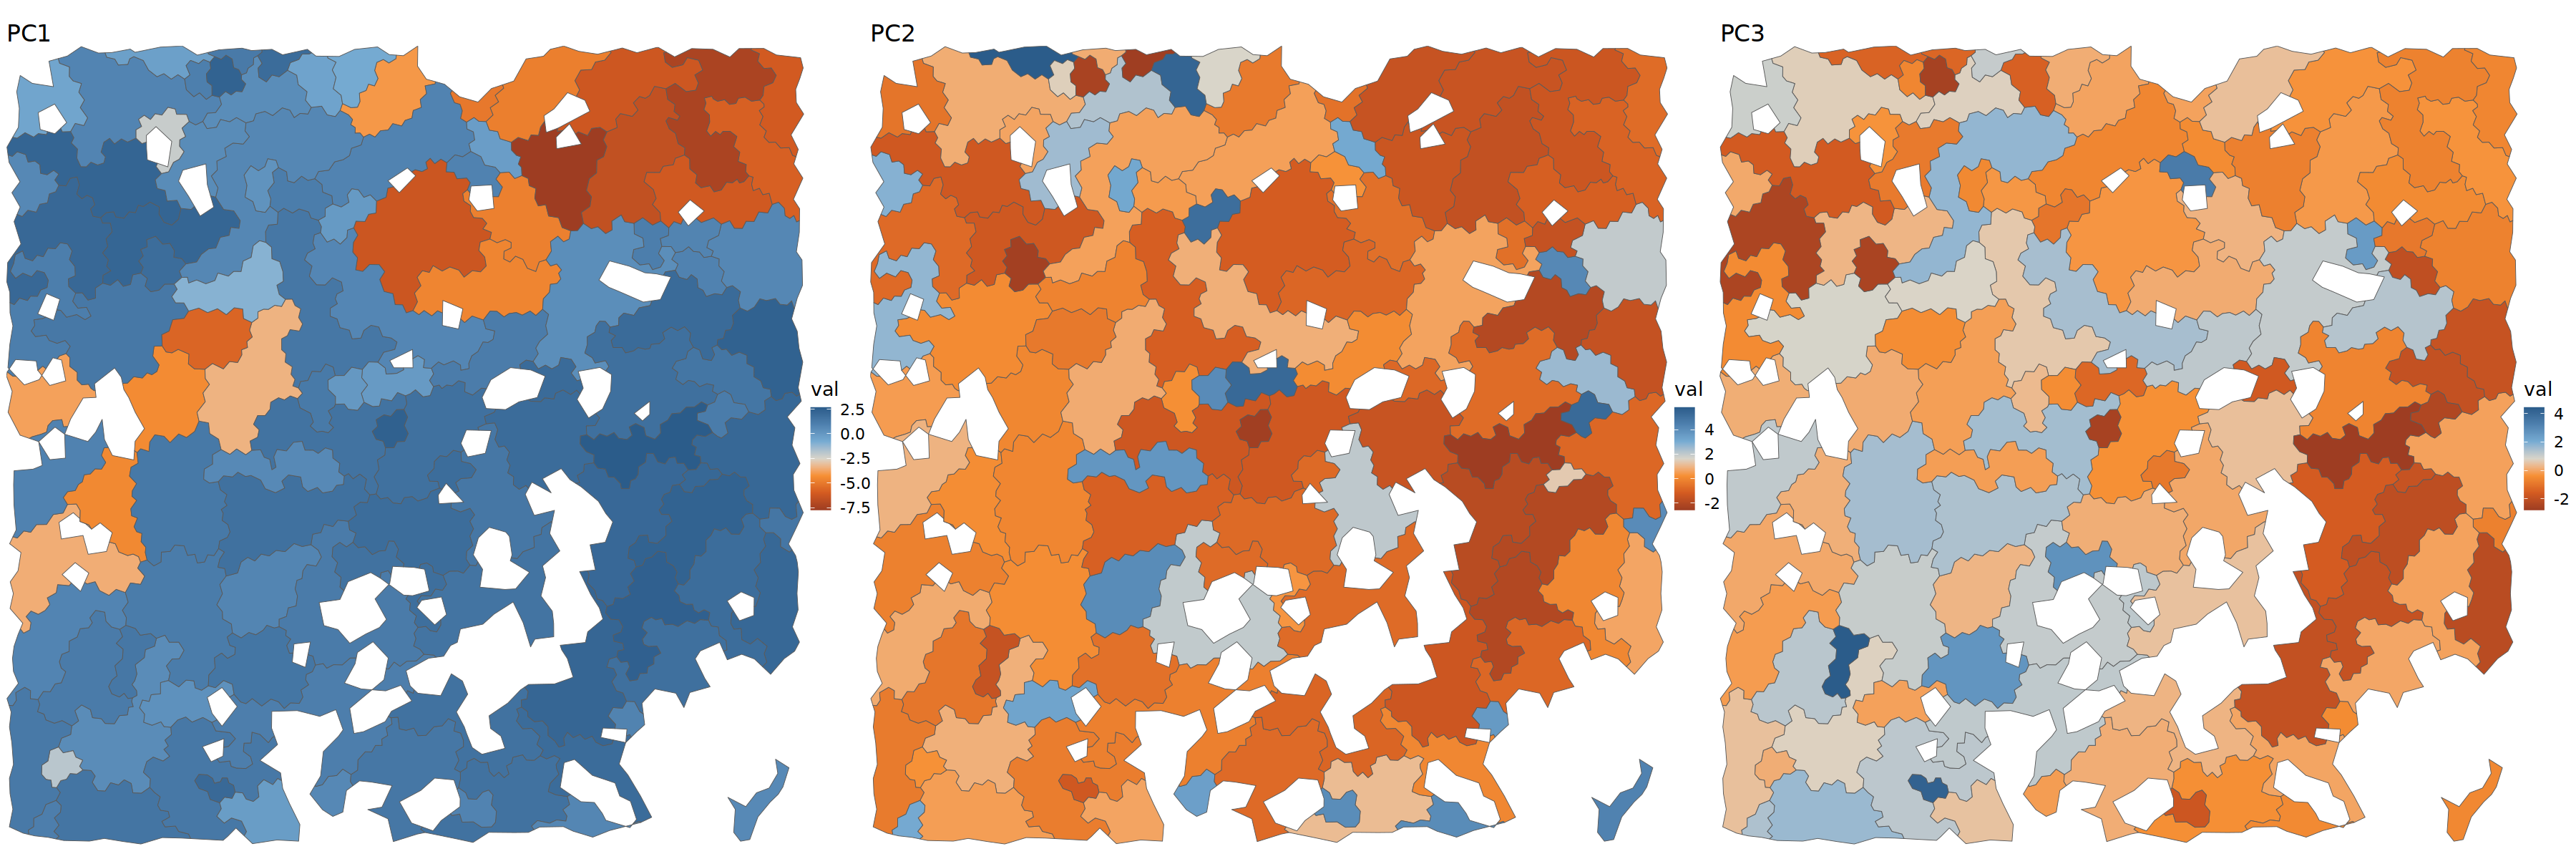

In [10]:
fig.size(10, 30)
purrr::map(1:3, function(i) {
    ggplot(cbind(aggs$meta_data, val=aggs$pcs[, i])) + 
        geom_sf(aes(geometry = shape, fill = val)) + 
        theme_void(base_size = 16) + 
        coord_sf(expand = FALSE) + 
        scale_fill_gradient2_tableau() + 
        guides(color = 'none') + 
        labs(title = glue('PC{i}')) + 
        NULL 
}) %>% 
    purrr::reduce(`|`)


# Cluster and label tiles 

Let's treat each aggregate as a unit of analysis. 


In [11]:
library(Seurat)

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, saveRDS


Loading Seurat v5 beta version 
To maintain compatibility with previous workflows, new Seurat objects will use the previous object structure by default
To use new Seurat v5 assays: Please run: options(Seurat.object.assay.version = 'v5')



In [12]:
obj = Seurat::CreateSeuratObject(
    counts = aggs$counts, 
    meta.data = tibble::column_to_rownames(data.frame(dplyr::select(aggs$meta_data, -shape)), 'id')
)

## Seurat doesn't do sf shapes well 
obj@meta.data$shape = aggs$meta_data$shape

Do all the typical steps for Seurat clustering. 

In [13]:
.verbose = FALSE
obj = obj %>% 
    NormalizeData(normalization.method = 'LogNormalize', scale.factor = median(obj@meta.data$nCount_RNA), verbose = .verbose) %>% 
    ScaleData(features = rownames(obj), verbose = .verbose) %>% 
    RunPCA(npcs = 20, features = rownames(obj), verbose = .verbose) %>% 
    RunUMAP(verbose = .verbose, dims = 1:20) %>% 
    Seurat::FindNeighbors(features = 1:20, reduction = 'pca', verbose = .verbose) %>% 
    Seurat::FindClusters(verbose = .verbose, resolution = c(2))

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by ‘spam’

Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by ‘spam’



Let's see the aggregate clusters in UMAP and physical space. 

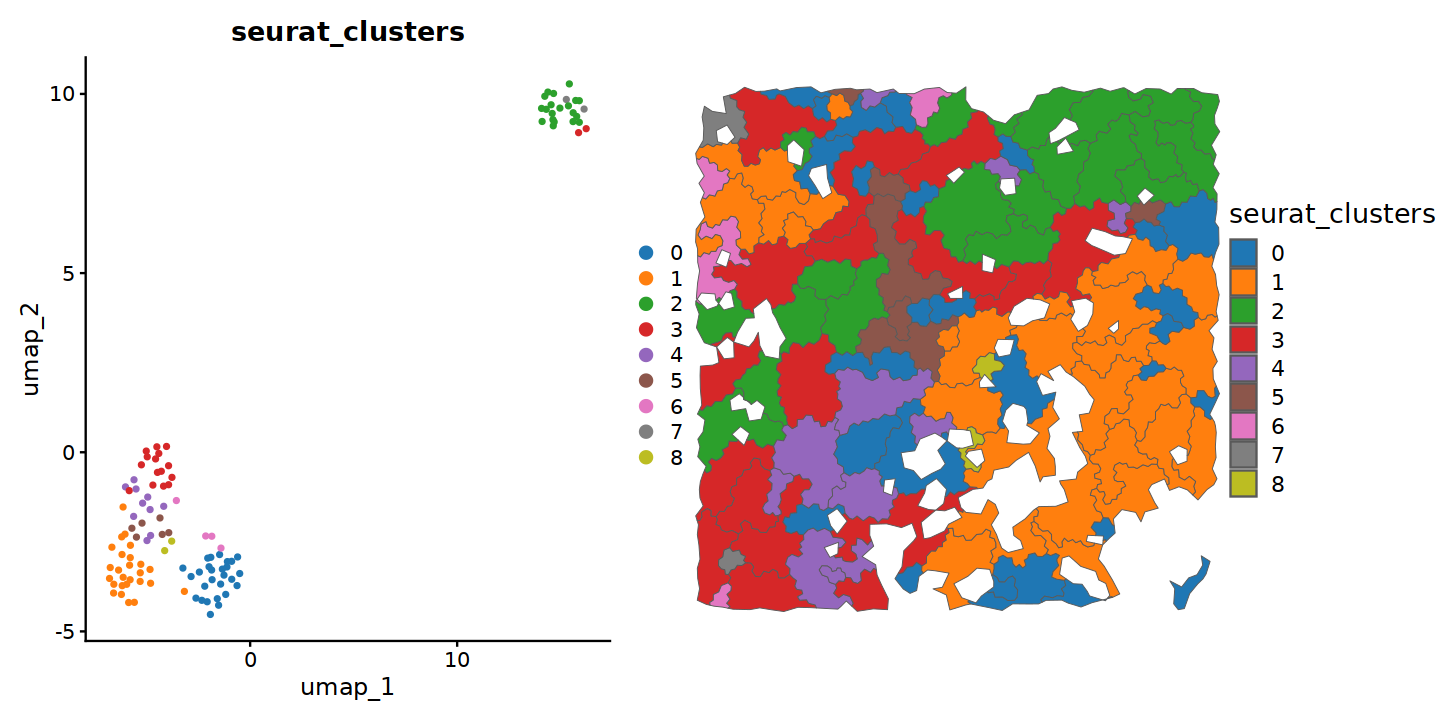

In [14]:
p1 = DimPlot(obj, reduction = 'umap', group.by = 'seurat_clusters') + scale_color_tableau('Classic 10') 
p2 = ggplot(obj@meta.data) + 
    geom_sf(aes(geometry = shape, fill = seurat_clusters)) + 
    theme_void(base_size = 16) + 
    coord_sf(expand = FALSE) + 
    scale_fill_tableau('Classic 10') + 
    # guides(color = 'none', fill = 'none') + 
    NULL 

fig.size(6, 12)
(p1 | p2) + plot_layout(widths = c(1, 1))

# Transfer agg information to cells

In [15]:
dmt$pts$spatial_cluster = obj@meta.data$seurat_clusters[dmt$pts$agg_id]

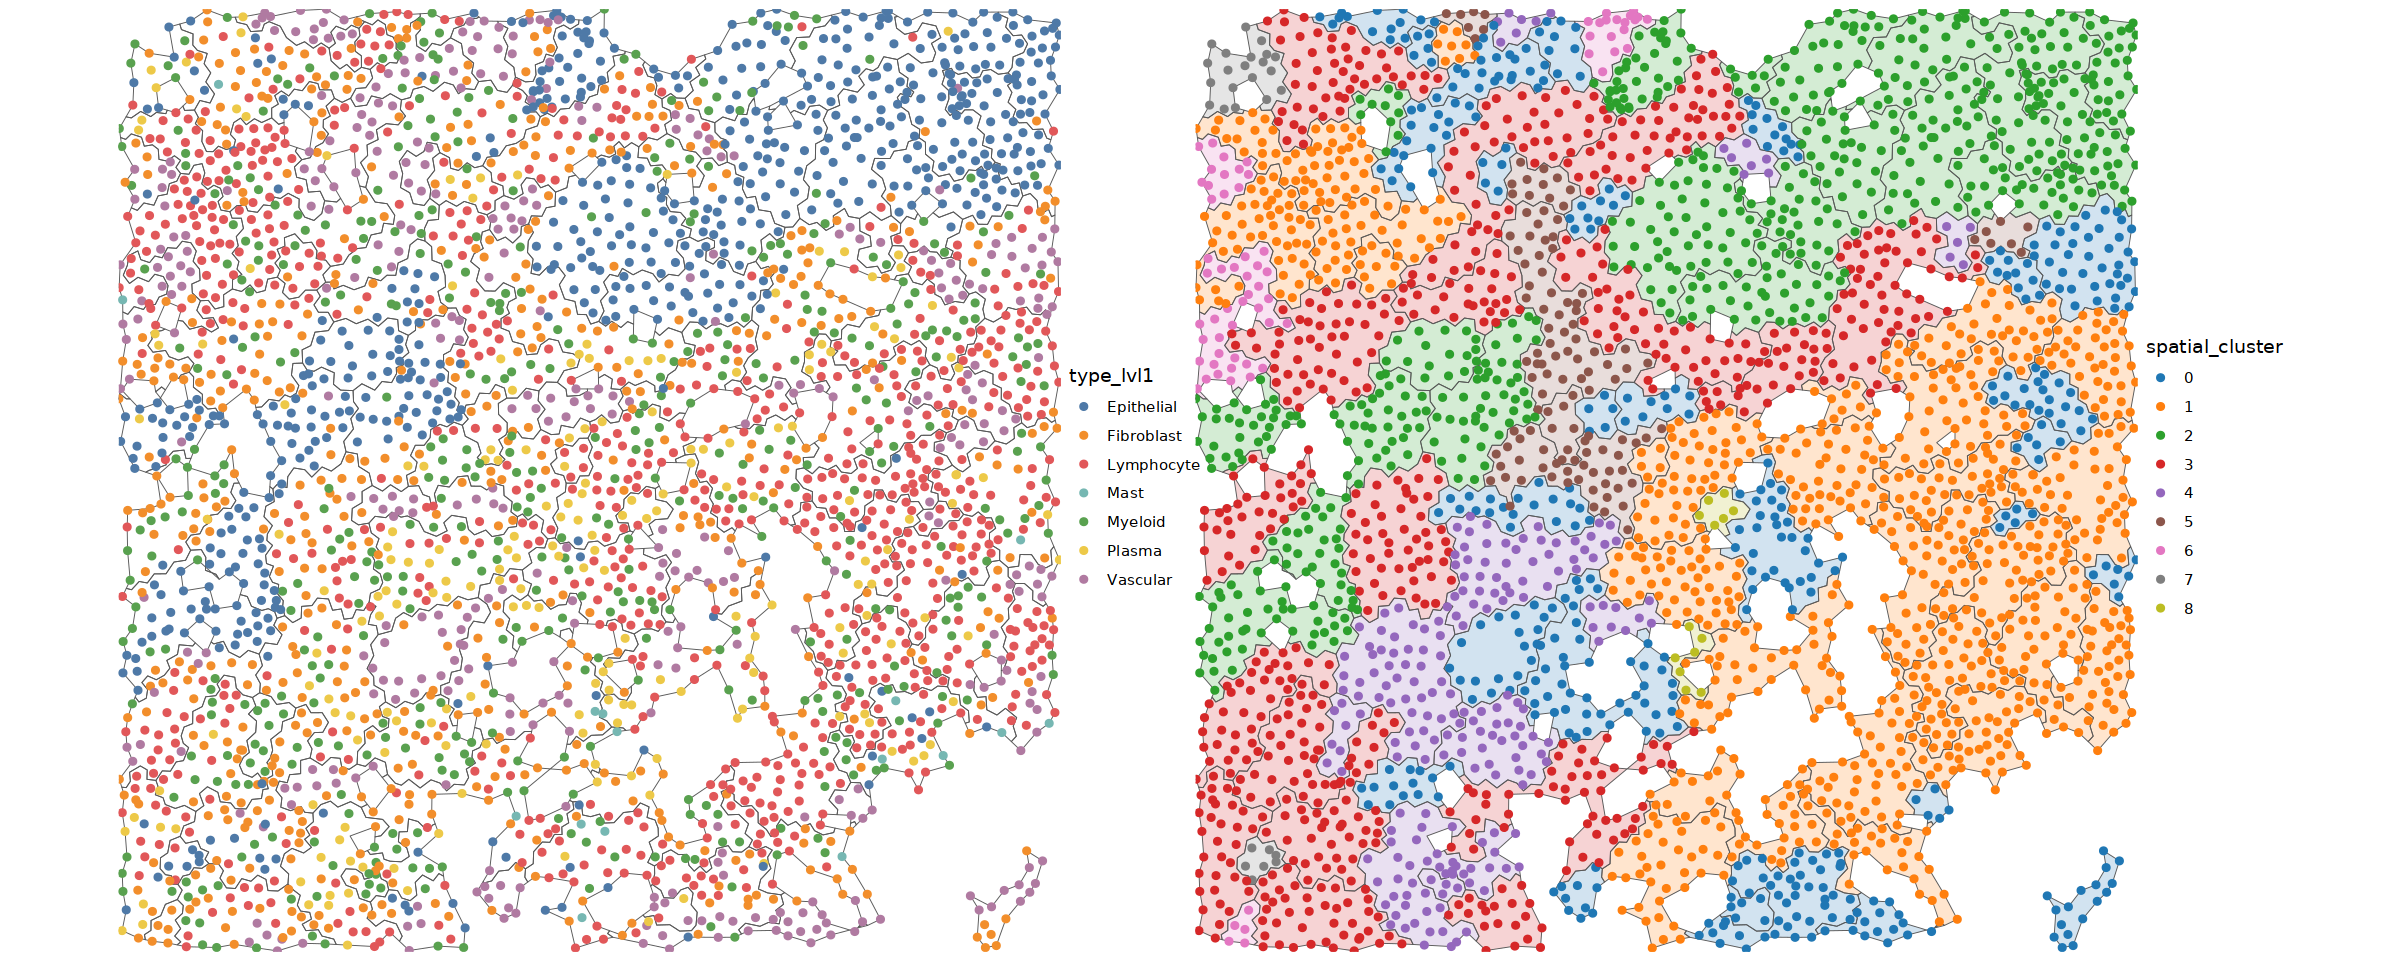

In [16]:
p1 = ggplot() + 
    geom_sf(data = obj@meta.data, aes(geometry = shape), fill = NA) + 
    geom_point(data = dmt$pts, aes(X, Y, color = type_lvl1)) + 
    scale_color_tableau() + 
    theme_void() + 
    coord_sf(expand = FALSE) + 
    NULL
p2 = ggplot() + 
    geom_sf(data = obj@meta.data, aes(geometry = shape, fill = seurat_clusters), alpha = .2) + 
    geom_point(data = dmt$pts, aes(X, Y, color = spatial_cluster)) + 
    scale_color_tableau('Classic 10') + 
    scale_fill_tableau('Classic 10') + 
    theme_void() + 
    guides(fill = 'none') + 
    coord_sf(expand = FALSE) + 
    NULL
fig.size(8, 20)
p1 | p2


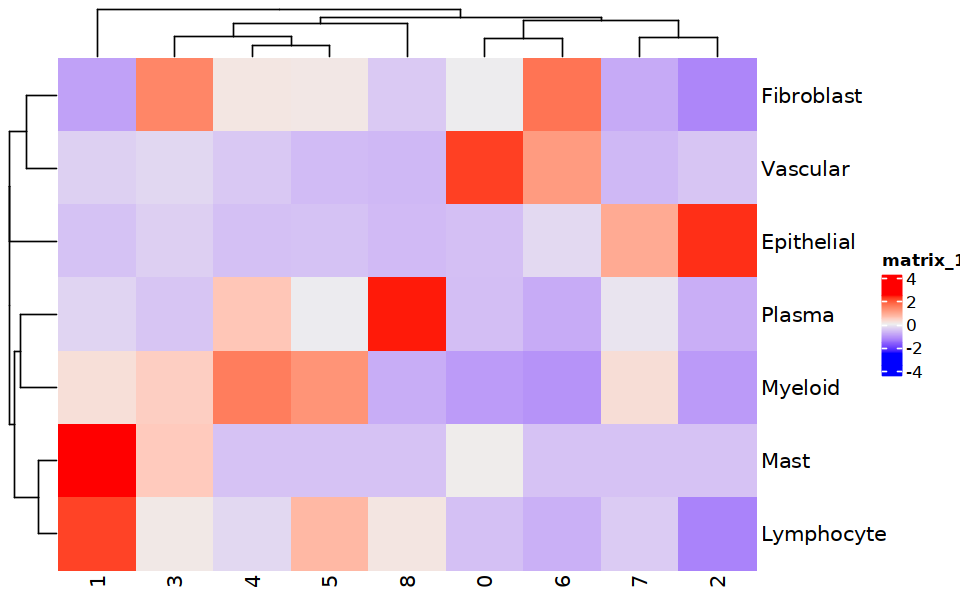

In [17]:
fig.size(5, 8)
dmt$pts %>% 
    with(table(type_lvl1, spatial_cluster)) %>% 
    prop.table(2) %>% 
    t %>% scale %>% t %>% 
    Heatmap()

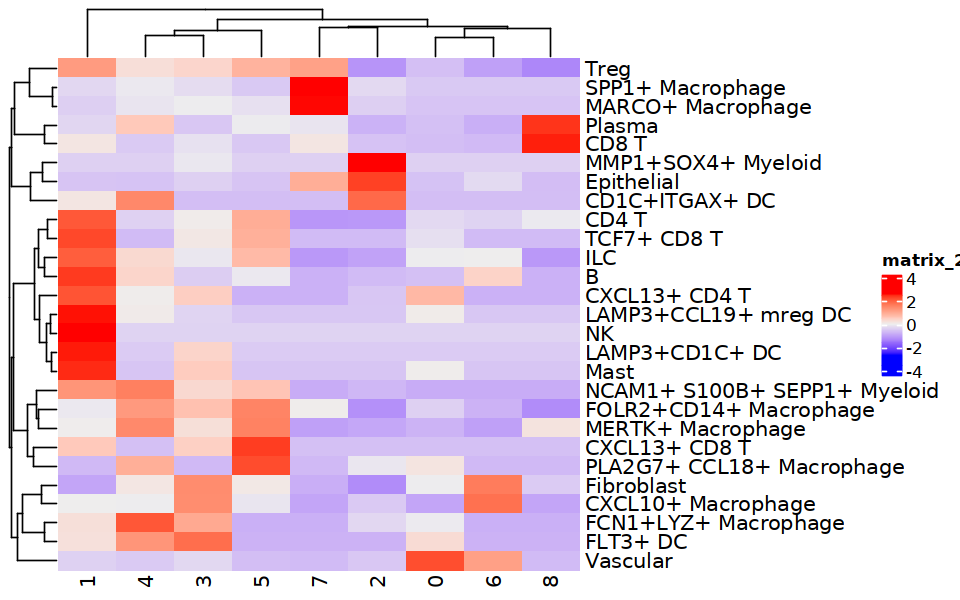

In [18]:
dmt$pts %>% 
    with(table(type_lvl2, spatial_cluster)) %>% 
    prop.table(2) %>% 
    t %>% scale %>% t %>% 
    Heatmap()